### This python notebook complements the report document (Capstone Report by SBaek.docx) and shows data analysis and calculation following the same numeric order of document sections

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Project roadmap (old)
1. Loading data/clean up
2. Dimensional Reduction (Principal Component Analysis)
3. Clustering Analysis
4. Classification model using Decision Tree
5. Model prediction for unknown dataset

# Project roadmap
1. Definition
2. Analysis
3. Methodology
4. Results
5. Conclusion

----

# Section 1. Definition

Please see the report document for the project overview and problem statement. 

# Section 2. Analysis

## 1-1. Import data/data clean up

* Among 10 features (except id number), I have decided perform feature selection where all the ratings informations were removed and time_on_site and listing features were combined as 'listing_per_day'
* Since some users began to sell on the first day they install the app, 'time_on_site' can be zero when there are number of listings recorded. In these cases, listing/time_on_site will generate 'Inf.' In order to avoid Inf happening, I have added 1 to all entries of 'time_on_site.' 

In [2]:
input_file = "data/Customer_activity.csv"
df = pd.read_csv(input_file, header = 0)
df2 = df.drop('install_date',axis=1)

# to avoid zero division, add one to time_on_site; does not skew the data much
df2['listing_per_day'] = df2['listing']/(df2['time_on_site']+1)

## 1-2. Separate users with no historic record of sales item
* This users are assumed to be 'New seller' without much analysis.
* Only a small fraction of total users have items on sale

In [3]:
df_active = df2[df2['listing']>0]
df_inact = df2[df2['listing']==0]

print "only %.2f%% of the listed users has items on sale!" % (float(len(df_active))/float(len(df2))*100)

only 8.07% of the listed users has items on sale!


* Remove ID feature (to be added later)

In [4]:
df_activeD = df_active.iloc[:,1:]

* Plot 'listing' vs 'sale'

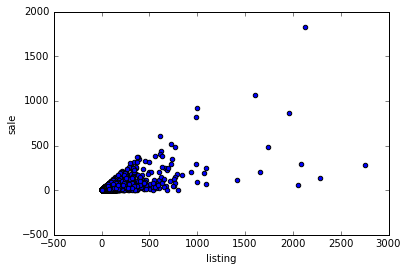

In [5]:
plt.scatter(df_active['listing'],df_active['sale'])
plt.xlabel('listing')
plt.ylabel('sale')

# 2. Dimensional Reduction
#### Total 9 features reduced to ?? features

## 2-1. feature scaling
* Normalize each column before applying principal component analysis

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_activeD), columns = df_activeD.columns)

# all columns are now 'scaled'
df_scaled.head()

,time_on_site,positive_rating,neutral_rating,negative_rating,listing,listing_gmv,sale,buyers,gmv,listing_per_day
0,0.938272,0.000699,0.0,0.0,0.000000,0.000121,0.000548,0.000627,0.000431,0.000010
1,0.061728,0.000000,0.0,0.0,0.014146,0.006135,0.000000,0.000000,0.000000,0.082986
2,0.320988,0.000000,0.0,0.0,0.002902,0.004281,0.000000,0.000000,0.000000,0.004005
3,0.024691,0.000000,0.0,0.0,0.000363,0.000815,0.000000,0.000000,0.000000,0.008162
4,0.703704,0.000000,0.0,0.0,0.002902,0.002426,0.000548,0.000627,0.001079,0.001783


## 2-2. PCA

* I have excluded all ratings features (positive, neutral, negative) because most of the ratings are on positive side and only a few negative/neutral ones. 
* Instead of including all three ratings separately, I think it'd be better to combine all into one scalable variable such as rating stars in Netflix or Amazon ratings. This process, however, was skipped for this study.

In [9]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_scaled.iloc[:,5:])  # including columns ['listing_gmv' ~ 'listing_per_day']
print pca.explained_variance_ratio_

[  6.20794214e-01   2.10112130e-01   1.32640302e-01   3.62197410e-02
   2.33612435e-04]


### Based on the PCA, I chose the top three dimensions and the feature dimensions now became 3 from the previous 5. I have tried and included other columns, but the PCA consistently computes three dimensions can adequately explain the variance of the data.

In [10]:
pca2 = PCA(n_components=3).fit(df_scaled.iloc[:,5:])
df_reduced = pca2.transform(df_scaled.iloc[:,5:])

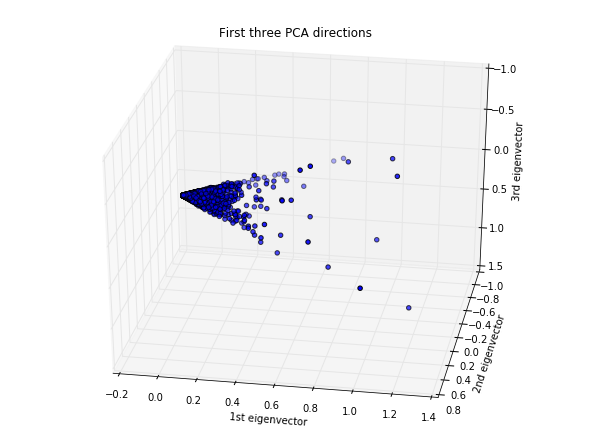

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=-100)

ax.scatter(df_reduced[:, 0], df_reduced[:, 1], df_reduced[:, 2], c='b',
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
#ax.w_zaxis.set_ticklabels([])

plt.show()

# 3. Clustering Analysis

## 3-1. Assumption

#### I previously assumed that the sellers with no listing were categorized as 'new seller,' therefore the remaining 'active' sellers will need to be segmented into THREE groups.
1. Casual seller
2. Business seller
3. Top seller

#### After PCA, clustering analysis does not label the data, but rather segregates into group (in this case, three) purely based on the data; it's up to a human modeler to label them later, meaningfully.

## 3-2. Clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
# three clusters predefined. The new seller group was already segregated in the earlier step.

n = 3
clusters = KMeans(init='k-means++', n_clusters=n, n_init=10, max_iter = 500)
clusters.fit(df_reduced)

print clusters

KMeans(copy_x=True, init='k-means++', max_iter=500, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [13]:
clusters.cluster_centers_

array([[ -3.29348187e-03,   1.72185146e-04,   1.13495131e-04],
       [  5.58350896e-02,  -4.60606475e-03,  -2.60212705e-03],
       [  3.49263549e-01,   3.39561551e-02,   8.95053444e-03]])

In [14]:
cl_labels = clusters.labels_  # labeling cluster number for ALL entry (97423 active entry)

In [15]:
df_active['cluster'] = cl_labels

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## 3-3. Data Labeling with group numbers

* Merge the labeled data for 'active sellers' to the original data frame

In [16]:
df_clustered = pd.merge(df, df_active[['id','cluster']],on='id',how='left')

* Add 3 to the 'new seller' group

In [17]:
df_clusteredAll = df_clustered.fillna(3)

### Labeling based on average listings per each group

In [18]:
group_listing = df_clusteredAll['listing'].groupby(df_clusteredAll['cluster'])
group_listing.mean()

cluster
0.0      8.088428
1.0     89.644224
2.0    498.802721
3.0      0.000000
Name: listing, dtype: float64

### As shown above, theaverage listings per each labeled group were computed. It is now possible to determine which group belongs to which predefined seller groups.


* Group 0: casual seller (avg 8.1 listings)
* Group 1: business seller (avg 89.6 listings)
* Group 2: top seller (avg 498.8 listings)
* Group 3: new seller (none listed)

## 3-4. Export to csv file

In [19]:
df_clusteredAll.to_csv('All_data_clustered.csv')
df_clusteredAll[df_clusteredAll['cluster']==0].to_csv('data_casual_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==1].to_csv('data_business_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==2].to_csv('data_top_seller.csv')
df_clusteredAll[df_clusteredAll['cluster']==3].to_csv('data_new_seller.csv')


# 4. Classification model using Decision Tree

* Now the clustering the seller is done. 
* Based on the seller segregation done in the previous step, we may be able to predict which group a unknown seller belongs when features of the seller are known.
* I used Decision Tree classifier to train the model.

## 4-1. splitting data into train/test sets

In [20]:
# separate the data into 'Features' and 'Labels' (or 'groups')
# And then, split them into 70-30 ratio for training and testing datasets

model_features = df_clusteredAll[['listing','listing_gmv','sale','buyers','gmv']]
model_groups = df_clusteredAll['cluster']

from sklearn.cross_validation import train_test_split
def shuffle_split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = shuffle_split_data(model_features, model_groups)

## 4-2. Define performance metrics

In [21]:
from sklearn.metrics import mean_squared_error
def performance_metric(y_true, y_predict):
    error = mean_squared_error(y_true, y_predict)
    return error

## 4-3. Train the model

#### Here I present two different decision tree models. I should have chosen the better model, but it is notable to present both of them because this might cast some question in quality of the model fit.


#### Initially, the model was calibrated only with 'min_samples_split' variable (model 1), which defines the minimum number of samples required to split an internal node, but later also tweaked 'max_depth' (maximum depth of the tree) (model 2).

### Findings
#### I used scikit-learns cross validation and grid search tools and tested various numbers for these parameters and found out that when min_samples_split is the only variable, min_samples_split = 100 would be the optimal parameter for the model
#### However, when 'max_depth' was also used in grid search function, then the optimal min_sample_split is 10. As seen in the figure below, this value of 10 would most likely suffer from the high bias problem (underfitting).
#### Based on the findings here, it seems 'max_depth' is more sensitive in fitting the decision tree then 'min_sample_split' variable.

In [22]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# first model with only 'min_samples_split' calibrated

def fit_model(X,y):
    # desicion tree classifier object
    clf = DecisionTreeClassifier()
    
    # parameters to use for tuning
    parameters ={'min_samples_split':(10, 50, 100, 5000)}
    
    # some scoring function
    scoring_function = make_scorer(mean_squared_error, greater_is_better = False)
    
    # grid search
    classi = GridSearchCV(clf, param_grid = parameters, scoring=scoring_function)
    classi.fit(X,y)
    
    return classi.best_estimator_

# -----------------------------------------------------------------------------
# second model with 'min_samples_split' and 'max_depth' calibrated

def fit_model2(X,y):
    # desicion tree classifier object
    clf = DecisionTreeClassifier()
    
    # parameters to use for tuning
    parameters ={'min_samples_split':(10, 50, 100, 5000),'max_depth':(1,3,5,7,9)}
    
    # some scoring function
    scoring_function = make_scorer(mean_squared_error, greater_is_better = False)
    
    # grid search
    classi2 = GridSearchCV(clf, param_grid = parameters, scoring=scoring_function)
    classi2.fit(X,y)
    
    return classi2.best_estimator_

classi = fit_model(model_features, model_groups)
classi2 = fit_model2(model_features, model_groups)

## 4-4. Learning Curve

In [23]:
def learning_curves(X_train, y_train, X_test, y_test):
    
    # Create the figure window
    fig = plt.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 100)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    # for k, depth in enumerate([1,3,6,10]):
    for k, split in enumerate([10, 50, 100, 5000]):
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            classifier = DecisionTreeClassifier(min_samples_split= split)
            
            # Fit the learner to the training data
            classifier.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], classifier.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, classifier.predict(X_test))
            

    
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('Minimum split samples = %s'%(split))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
        ax.set_ylim([0, 0.01])
        
    # Visual aesthetics
    fig.suptitle('Decision Tree Classifier Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

### Learning curve with minimum split samples = 100 looks better than other three.

/Users/seungjinbaek/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


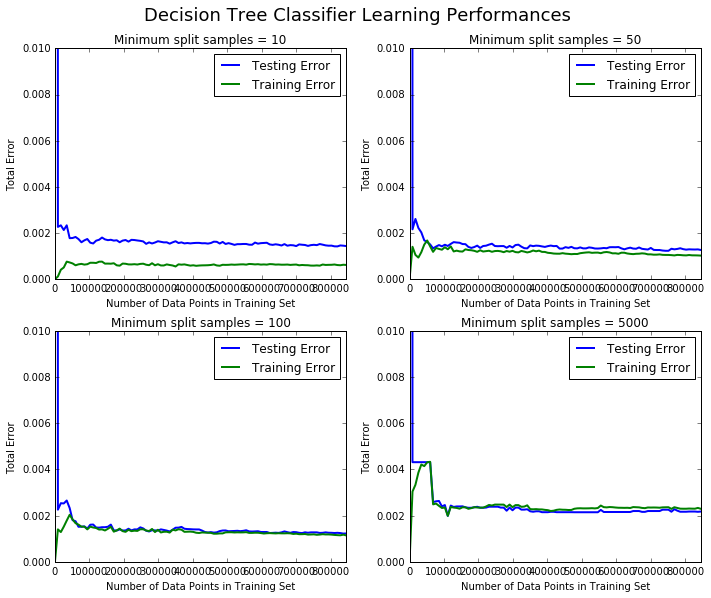

In [24]:
learning_curves(X_train,y_train,X_test,y_test)

In [25]:
def learning_curves(X_train, y_train, X_test, y_test):
    
    
    # Create the figure window
    fig = plt.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 100)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([1,3,5,9]):
    
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            classifier = DecisionTreeClassifier(max_depth = depth)
            
            # Fit the learner to the training data
            classifier.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], classifier.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, classifier.predict(X_test))
            

    
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
        #ax.set_xlim([0, 200000])
        ax.set_ylim([0, 0.01])
    
    # Visual aesthetics
    fig.suptitle('Decision Tree Classifier Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

### Learning curve with Maximum depth = 9 looks better than other three.

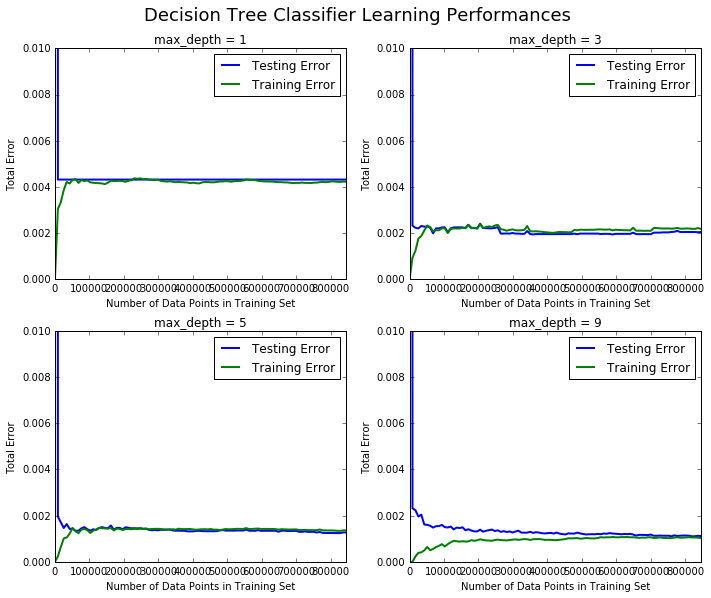

In [26]:
learning_curves(X_train,y_train,X_test,y_test)

In [27]:
classi.get_params()


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [28]:
classi2.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

# 5. Model prediction

## 5-1. Testing model prediction

* See prediction tests below; the last entry is segregated and labeled as group 2 (top seller) in the clustering analysis.
* But, when I tested this seller using the first decision tree model, it was predicted to be in the group 1 (Business seller)!
* Please see the next section for quantitative evaluation of the classifier.

In [29]:
# features: ['listing','listing_gmv','sale','buyers','gmv']
new_seller = [[0,0,0,0,0]]   # new seller
new_seller = [[100,1000,10,10,100]] # casual
new_seller = [[100,1000,100,100,1000]] # business
new_seller = [[249,8466,174,155,5553]] # top seller
new_seller = [[66,19674,2,2,33]] # top seller or business?


#new_seller = [[0,0,0,0,0]]
new_prediction = classi.predict(new_seller)
new_prediction2 = classi2.predict(new_seller)
print new_prediction, new_prediction2

[ 1.] [ 2.]


## 5-2. Quantitative evaluation of the model

* It is shown that the second classifier model (classi2) presents the better F1 score for groups 2 and 3.

In [30]:
from sklearn.metrics import classification_report

model_prediction = classi.predict(model_features)
print(classification_report(model_groups,model_prediction))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     92731
        1.0       0.92      0.78      0.84      4545
        2.0       0.86      0.78      0.81       147
        3.0       1.00      1.00      1.00   1110351

avg / total       1.00      1.00      1.00   1207774



In [31]:
model_prediction = classi2.predict(model_features)
print(classification_report(model_groups,model_prediction))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     92731
        1.0       0.95      0.77      0.85      4545
        2.0       0.98      0.88      0.93       147
        3.0       1.00      1.00      1.00   1110351

avg / total       1.00      1.00      1.00   1207774



# Remarks

* It's been a fun project to analyze the seller datasets with limited available information.

### My take on this project contains two main parts.

#### part 1
* With the given information, I have segregated the sellers into four groups.

#### part 2
* And then assuming this group segregation was correctly done, I trained a decision tree model for prediction on future/unknown sellers.

# Future recommendation
* Different classifier/different sets of calibration parameters would be beneficial to build a more robust model
* Create a scalable user ratings from the existing three distinct ratings (good, neutral, bad)